<a href="https://github.com/labrijisaad/LLM-RAG/blob/main/notebooks/RAG_LLM_experiments.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/Open%20in-GitHub-blue.svg" alt="Open In GitHub"/>
</a>

## <center><a><span style="color:red">`OpenAI LLM` - RAG LLM Experiments</span></a></center>

<p align="center">
  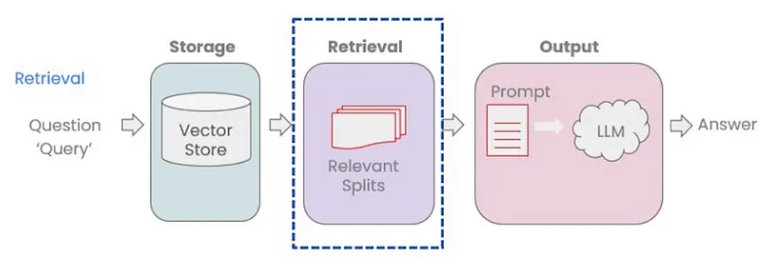
</p>

### <a><span style="color:green">`Class Based` - Model Inference Manager</span></a>

In [1]:
import numpy as np
import requests
import faiss
import yaml
import re

from tqdm.auto import tqdm

In [2]:
class ModelInferenceManager:
    def __init__(self, api_key, models_config):
        self.api_key = api_key
        self.models_config = models_config
        self.model = None
        self.input_token_price = None
        self.output_token_price = None

    def set_model(self, model_name):
        for group in self.models_config["models"]:
            for variant in group["variants"]:
                if variant["model"] == model_name:
                    self.model = model_name
                    self.input_token_price = variant["input_price_per_token"]
                    self.output_token_price = variant["output_price_per_token"]
                    return
        raise ValueError(f"Model {model_name} not found in configuration.")

    def query_openai(self, prompt_text, max_completion_tokens=100, temperature=0.7):
        if not self.model:
            raise ValueError(
                "Model not set. Please use set_model() to set a model before querying."
            )
        url = "https://api.openai.com/v1/chat/completions"
        headers = {"Authorization": f"Bearer {self.api_key}"}
        payload = {
            "model": self.model,
            "messages": [{"role": "user", "content": prompt_text}],
            "max_tokens": max_completion_tokens,
            "temperature": temperature,
        }

        try:
            response = requests.post(url, headers=headers, json=payload)
            if response.status_code == 200:
                data = response.json()
                content = data["choices"][0]["message"]["content"]
                usage = data["usage"]
                return content, usage
            else:
                return (
                    f"HTTP Error {response.status_code}: {response.json().get('error', {}).get('message', 'An unspecified error occurred')}",
                    None,
                )
        except requests.RequestException as e:
            return f"Connection error: {e}", None

    def calculate_cost(self, usage):
        if usage:
            total_price = (usage["prompt_tokens"] * self.input_token_price) + (
                usage["completion_tokens"] * self.output_token_price
            )
            return total_price
        else:
            return None

    def determine_expertise_area(
        self, user_question, max_completion_tokens, temperature):
        prompt_text = f"""Based on the question provided, identify the relevant expertise area(s). Return your answer in the format: 
        'expertise1, expertise2, ...'. Provide only the expertise areas as a comma-separated list, no additional explanations are needed.
        Here is the user Question:
        {user_question}
        """
        response, usage = self.query_openai(
            prompt_text, max_completion_tokens, temperature
        )
        return response.strip(), (
            usage if response else "Error determining expertise area."
        )

    def prepare_prompt_for_llm(self, expertise_area, user_question, context_documents):
        prompt = (
            f"You are an expert in '{expertise_area}'. A user has asked for help with the following question: "
            f"'{user_question}'. Please provide insights using only the information from the provided documents. "
            "If certain aspects are ambiguous or the documents do not fully address the question, please make educated inferences based on your expertise.\n\n"
            "Here are the documents provided:\n\n"
        )
        for i, document in enumerate(context_documents, start=1):
            prompt += f'Document {i}:\n"""\n{document}\n"""\n\n'
        prompt += "Given your expertise and the information provided in these documents, synthesize the key insights to craft a detailed and relevant response to the above question.\n\n"
        prompt += "Start your response below:\n\n"
        return prompt

# Load Model Configs function
def load_models_config(config_file_path):
    with open(config_file_path, "r") as config_file:
        try:
            models_config = yaml.safe_load(config_file)
            return models_config
        except yaml.YAMLError as exc:
            print(exc)
            return None

### <a><span style="color:green">`Class Based` - Text Vectorization</span></a>

In [3]:
class SemanticVectorizer:
    def __init__(self, api_key, models_config):
        self.api_key = api_key
        self.models_config = models_config
        self.model = None
        self.usage_price_per_token = 0
        self.texts = []
        self.embeddings = []
        self.faiss_index = None

    def set_model(self, model_name):
        found = False
        for group in self.models_config["models"]:
            for variant in group["variants"]:
                if variant["model"] == model_name:
                    self.model = model_name
                    self.usage_price_per_token = variant.get("usage_price_per_token", 0)
                    found = True
                    break
            if found:
                break
        if not found:
            raise ValueError(f"Model {model_name} not found in configuration.")

    def preprocess_text(self, text):
        """
        Preprocesses the text before embedding.
        """
        text = text.lower()
        return text.replace("\n", " ").strip()

    def read_and_process_markdown(self, file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
        sections = re.split(r"\n(#{1,3} .*)\n", text)
        self.texts = [self.preprocess_text(sections[0])] + [
            self.preprocess_text(f"{sections[i]}\n{sections[i + 1]}")
            for i in range(1, len(sections), 2)
        ]
        return self.texts

    def query_openai_embedding(self, text):
        preprocessed_text = self.preprocess_text(text)
        url = f"https://api.openai.com/v1/embeddings"
        headers = {"Authorization": f"Bearer {self.api_key}"}
        payload = {
            "input": preprocessed_text,
            "model": self.model,
        }
        response = requests.post(url, headers=headers, json=payload)
        if response.status_code == 200:
            data = response.json()
            embedding = np.array(data["data"][0]["embedding"], dtype="float32")
            return embedding, data.get("usage", {})
        else:
            print(
                f"Failed to generate embedding: Status code {response.status_code}, Response: {response.text}"
            )
            return None, None

    def generate_embeddings(self):
        total_cost = 0
        for text in tqdm(self.texts):
            embedding, usage = self.query_openai_embedding(text)
            if embedding is not None:
                self.embeddings.append(embedding)
                total_cost += self.calculate_cost(usage)
        self.embeddings = np.array(self.embeddings)
        self.create_faiss_index()
        return total_cost

    def create_faiss_index(self):
        if self.embeddings.size > 0:
            dimension = self.embeddings.shape[1]
            self.faiss_index = faiss.IndexFlatL2(dimension)
            self.faiss_index.add(self.embeddings)
        else:
            print("No embeddings to add to FAISS index.")

    def search_similar_sections(self, query_text, num_results):
        query_embedding, _ = self.query_openai_embedding(query_text)
        if self.faiss_index is None:
            raise ValueError(
                "FAISS index is not initialized. Please create the index before searching."
            )
        if query_embedding is None:
            return []
        distances, indices = self.faiss_index.search(
            np.array([query_embedding], dtype="float32"), num_results
        )
        return [self.texts[idx] for idx in indices[0] if idx < len(self.texts)]


    def save_faiss_index(self, index_path):
        if self.faiss_index:
            faiss.write_index(self.faiss_index, index_path)
        else:
            print("FAISS index is not initialized.")

    def load_faiss_index(self, index_path):
        self.faiss_index = faiss.read_index(index_path)

    def calculate_cost(self, usage):
        total_tokens = usage.get("total_tokens", 0)
        total_price = total_tokens * self.usage_price_per_token
        return total_price

### <a><span style="color:green">`Class Based` - LLM RAG Pipeline</span></a>

In [4]:
class QueryPipeline:
    def __init__(self, openai_api_key, models_config):
        self.embedder = SemanticVectorizer(openai_api_key, models_config)
        self.model_inference_manager = ModelInferenceManager(openai_api_key, models_config)

    def setup_semantic_database(self, markdown_path, embedding_model):
        self.embedder.set_model(embedding_model)
        self.embedder.read_and_process_markdown(markdown_path)
        self.embedder.generate_embeddings()
        self.embedder.create_faiss_index()

    def find_similar_documents(self, query_text, num_results):
        similar_docs = self.embedder.search_similar_sections(query_text, num_results)
        return similar_docs

    def determine_expertise_and_prepare_prompt(self, user_query, similar_docs, inference_model, max_completion_tokens, temperature):
        self.model_inference_manager.set_model(inference_model)
        identified_expertise_area, _ = self.model_inference_manager.determine_expertise_area(
            user_query, max_completion_tokens, temperature
        )
        context_enhanced_prompt = self.model_inference_manager.prepare_prompt_for_llm(
            identified_expertise_area, user_query, similar_docs
        )
        return context_enhanced_prompt

    def query_model_for_response(self, context_enhanced_prompt, max_completion_tokens, temperature):
        contextual_response, _ = self.model_inference_manager.query_openai(
            context_enhanced_prompt, max_completion_tokens, temperature
        )
        return contextual_response

#### Loading `OpenAI Key` & `Model Configuration` 

In [5]:
# Laod OpenAI Key
with open("../secrets/credentials.yml", "r") as credentials_file:
    config = yaml.safe_load(credentials_file)
OPENAI_API_KEY = config["OPENAI_CREDENTIALS"]

# Load Models Config
MODELS_CONFIG = load_models_config("../config/models_config.yml")
MODELS_CONFIG.keys()

dict_keys(['models'])

#### Usage

In [6]:
# Initialize the QueryPipeline
query_pipeline = QueryPipeline(OPENAI_API_KEY, MODELS_CONFIG)

# Set up the semantic database
query_pipeline.setup_semantic_database(
    markdown_path="../data/raw/mock_markdown.md",
    embedding_model="text-embedding-3-small"
)

  0%|          | 0/50 [00:00<?, ?it/s]

###### Example 1

In [7]:
# Step 2: Find similar documents
query_text = "Where in these files is Health??"
similar_docs = query_pipeline.find_similar_documents(
    query_text=query_text,
    num_results=3
)

# Step 3: Determine expertise area and prepare the prompt
context_enhanced_prompt = query_pipeline.determine_expertise_and_prepare_prompt(
    user_query=query_text,
    similar_docs=similar_docs,
    inference_model="gpt-3.5-turbo-0125",
    max_completion_tokens=150,
    temperature=0.2
)

# Step 4: Query the model for a response
contextual_response = query_pipeline.query_model_for_response(
    context_enhanced_prompt=context_enhanced_prompt,
    max_completion_tokens=1500,
    temperature=0.7
)

print(context_enhanced_prompt)
print("--------")
print(contextual_response)

You are an expert in 'Healthcare data analysis, Information retrieval'. A user has asked for help with the following question: 'Where in these files is Health??'. Please provide insights using only the information from the provided documents. If certain aspects are ambiguous or the documents do not fully address the question, please make educated inferences based on your expertise.

Here are the documents provided:

Document 1:
"""
# comprehensive guide on health and fitness  health and fitness have become central to modern lifestyle, emphasizing the importance of regular exercise, balanced diet, and mental well-being.
"""

Document 2:
"""
## healthcare  in healthcare, ai is being used to make more accurate diagnoses, predict patient outcomes, and personalize patient treatment plans.
"""

Document 3:
"""
### types of physical activities  - **aerobic exercises**: enhance heart and lung health and improve stamina. - **strength training**: builds muscle strength and improves metabolism. -

###### Example 2

In [8]:
# Step 2: Find similar documents
query_text = "Where in these files is AI"
similar_docs = query_pipeline.find_similar_documents(
    query_text=query_text,
    num_results=3
)

# Step 3: Determine expertise area and prepare the prompt
context_enhanced_prompt = query_pipeline.determine_expertise_and_prepare_prompt(
    user_query=query_text,
    similar_docs=similar_docs,
    inference_model="gpt-3.5-turbo-0125",
    max_completion_tokens=150,
    temperature=0.2
)

# Step 4: Query the model for a response
contextual_response = query_pipeline.query_model_for_response(
    context_enhanced_prompt=context_enhanced_prompt,
    max_completion_tokens=1500,
    temperature=0.7
)

print(context_enhanced_prompt)
print("--------")
print(contextual_response)

You are an expert in 'Artificial Intelligence, Data Analysis'. A user has asked for help with the following question: 'Where in these files is AI'. Please provide insights using only the information from the provided documents. If certain aspects are ambiguous or the documents do not fully address the question, please make educated inferences based on your expertise.

Here are the documents provided:

Document 1:
"""
# introduction to ai  artificial intelligence (ai) has rapidly become a key technology in many industries, revolutionizing processes and efficiency.
"""

Document 2:
"""
# applications of ai  ai technology is not just a scientific discipline, but a driver of high-tech innovation and real-world applications.
"""

Document 3:
"""
## the rise of artificial intelligence  ai is transforming business, healthcare, and daily life, offering new possibilities in automation and smart technology.
"""

Given your expertise and the information provided in these documents, synthesize the

## Connect with me 🌐
<div align="center">
  <a href="https://www.linkedin.com/in/labrijisaad/">
    <img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn" style="margin-bottom: 5px;"/>
  </a>
  <a href="https://github.com/labrijisaad">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="GitHub" style="margin-bottom: 5px;"/>
  </a>
</div>